# Stocks Sentiment Analysis

In this project, I will analyze the sentiment towards stock movements using the RNN (Recurrent neural network) in Long short-term memory (LSTM) method. In the dataset used, a sentiment will have a value of 1 if it is a positive sentiment towards stock movements and will have a value of 0 if the opposite.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
#import smart_open
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
sentiment_data = pd.read_csv('stock_sentiment.csv')
sentiment_data

Text  Sentiment
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2     user I'd be afraid to short AMZN - they are lo...          1
3                                     MNTA Over 12.00            1
4                                      OI  Over 21.37            1
...                                                 ...        ...
5786  Industry body CII said #discoms are likely to ...          0
5787  #Gold prices slip below Rs 46,000 as #investor...          0
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1
5790  #Sensex, #Nifty climb off day's highs, still u...          1

[5791 rows x 2 columns]

In [3]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
sentiment_data.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
def no_punc(message):
    Test_no_punc = [char for char in message if char not in string.punctuation]
    Test_no_punc = ''.join(Test_no_punc)

    return Test_no_punc

In [7]:
sentiment_data['Text Without Punc'] = sentiment_data['Text'].apply(no_punc)

In [8]:
sentiment_data

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                                      Text Without Punc  
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...  
1     user AAP MOVIE 55 return for the FEAGEED indic...  
2     user Id be afraid to short AMZN  they are look...  
3                                      MNTA Over 1200    
4                                       OI  Over 2137    
...                                                 ...  
5786  Industry body CII said discoms are likely to s...  
5787  Gold prices slip below Rs 46000 as investors b...  
5788  Workers at Bajaj Auto have agreed to a 10 wage...  
5789  Sharemarket LIVE Sensex off day’s high up 600 ...  
5790  Sensex Nifty climb off days highs still up 2 K...  

[5791 rows x 3 columns]

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year'])

In [10]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [11]:
sentiment_data['Text Without Punc & Stopwords'] = sentiment_data['Text Without Punc'].apply(preprocess)

In [12]:
sentiment_data['Text Without Punc & Stopwords Joined'] = sentiment_data['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

In [13]:
sentiment_data

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                                      Text Without Punc  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   
1     user AAP MOVIE 55 return for the FEAGEED indic...   
2     user Id be afraid to short AMZN  they are look...   
3                                      MNTA Over 1200     
4                                       OI  Over 2137     
...                                                 ...   
5786  Industry body CII said discoms are likely to s...   
5787  Gold prices slip below Rs 46000 as investors b...   
5788  Workers at Bajaj Auto have agreed to a 10 wage...   
5789  Sharemarket LIVE Sensex off day’s high up 600 ...   
5790  Sensex Nifty climb off days highs still up 2 K...   

                          Text Without Punc & Stopwords  \
0     [kickers, watchlist, xide, tit, soq, pnk, cpw,...   
1     [movie, return, feageed, indicator, trades, aw...   
2     [afraid, short, amzn, looking, like, nearmonop...   
3                                                [mnta]   
4                                                    []   
...                                                 ...   
5786  [industry, body, cii, said, discoms, likely, s...   
5787  [gold, prices, slip, investors, book, profits,...   
5788  [workers, bajaj, auto, agreed, wage, cut, peri...   
5789  [sharemarket, live, sensex, high, points, nift...   
5790  [sensex, nifty, climb, days, highs, still, key...   

                   Text Without Punc & Stopwords Joined  
0     kickers watchlist xide tit soq pnk cpw bpz tra...  
1         movie return feageed indicator trades awesome  
2     afraid short amzn looking like nearmonopoly eb...  
3                                                  mnta  
4                                                        
...                                                 ...  
5786  industry body cii said discoms likely suffer n...  
5787  gold prices slip investors book profits amid c...  
5788  workers bajaj auto agreed wage cut period apri...  
5789  sharemarket live sensex high points nifty test...  
5790  sensex nifty climb days highs still key factor...  

[5791 rows x 5 columns]

positive sentiment

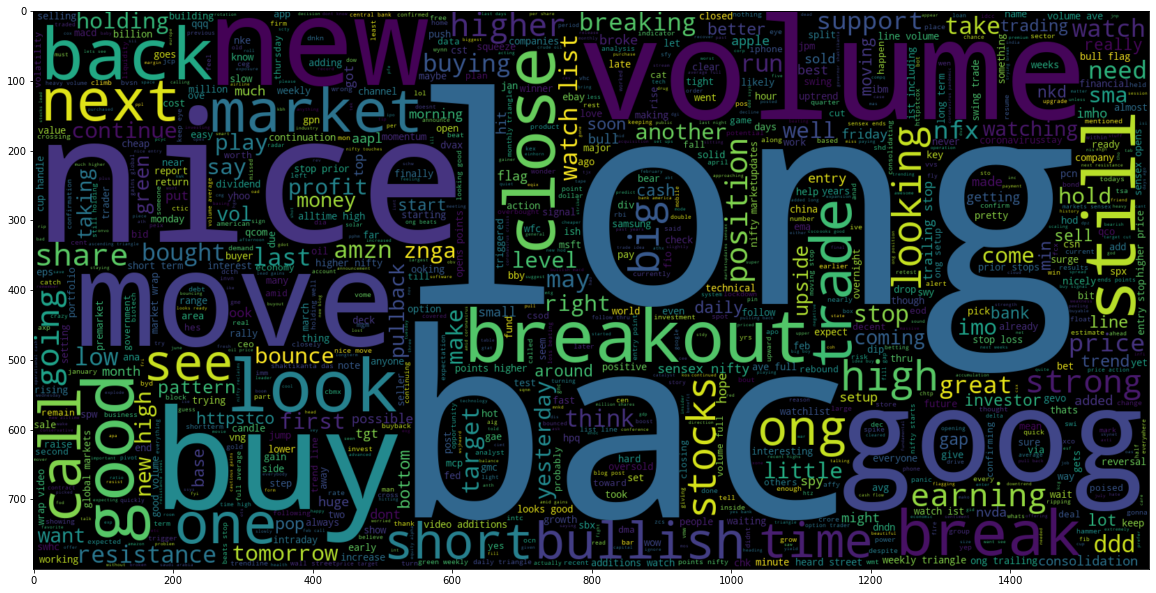

In [14]:
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(sentiment_data[sentiment_data['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

negative sentiment

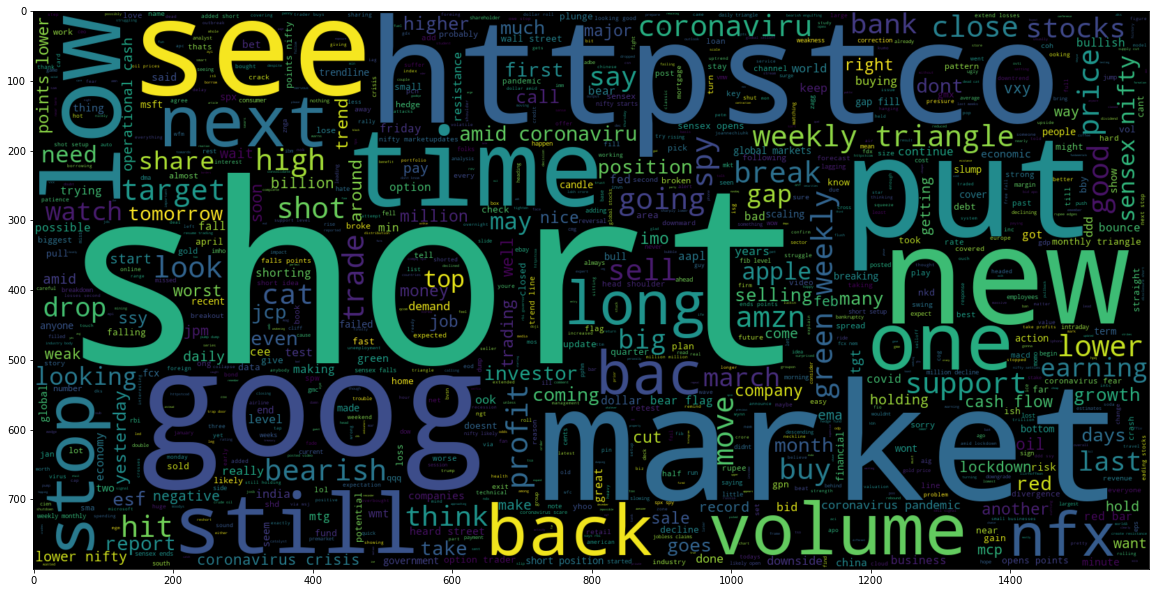

In [15]:
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(sentiment_data[sentiment_data['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
print(sentiment_data['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(sentiment_data['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [18]:
maxlen = -1
for doc in sentiment_data['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [19]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in sentiment_data['Text Without Punc & Stopwords Joined'] ]

In [20]:
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

Tokens

In [21]:
sentiment_data

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                                      Text Without Punc  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   
1     user AAP MOVIE 55 return for the FEAGEED indic...   
2     user Id be afraid to short AMZN  they are look...   
3                                      MNTA Over 1200     
4                                       OI  Over 2137     
...                                                 ...   
5786  Industry body CII said discoms are likely to s...   
5787  Gold prices slip below Rs 46000 as investors b...   
5788  Workers at Bajaj Auto have agreed to a 10 wage...   
5789  Sharemarket LIVE Sensex off day’s high up 600 ...   
5790  Sensex Nifty climb off days highs still up 2 K...   

                          Text Without Punc & Stopwords  \
0     [kickers, watchlist, xide, tit, soq, pnk, cpw,...   
1     [movie, return, feageed, indicator, trades, aw...   
2     [afraid, short, amzn, looking, like, nearmonop...   
3                                                [mnta]   
4                                                    []   
...                                                 ...   
5786  [industry, body, cii, said, discoms, likely, s...   
5787  [gold, prices, slip, investors, book, profits,...   
5788  [workers, bajaj, auto, agreed, wage, cut, peri...   
5789  [sharemarket, live, sensex, high, points, nift...   
5790  [sensex, nifty, climb, days, highs, still, key...   

                   Text Without Punc & Stopwords Joined  
0     kickers watchlist xide tit soq pnk cpw bpz tra...  
1         movie return feageed indicator trades awesome  
2     afraid short amzn looking like nearmonopoly eb...  
3                                                  mnta  
4                                                        
...                                                 ...  
5786  industry body cii said discoms likely suffer n...  
5787  gold prices slip investors book profits amid c...  
5788  workers bajaj auto agreed wage cut period apri...  
5789  sharemarket live sensex high points nifty test...  
5790  sensex nifty climb days highs still key factor...  

[5791 rows x 5 columns]

In [22]:
list_of_words = []
for i in sentiment_data['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [23]:
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'chea

In [109]:
### unique words
total_words = len(list(set(list_of_words)))
total_words

9268

In [230]:
## X = sentiment_data['Text Without Punc & Stopwords']
y = sentiment_data['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [231]:
X_train.shape

(5211,)

In [232]:
X_test.shape

(580,)

In [233]:
X_train

2723                [min, ema, short, thx, position, yet]
3091    [spw, first, solar, showing, signs, fatigue, s...
4978    [chinaâ, burgeoning, market, bonds, backed, mo...
4057                                     [bull, flagging]
4493                 [breaked, sma, clear, ptrend, radar]
                              ...                        
2205    [csx, getting, barrons, bounce, resistance, wo...
77       [host, mostcongrats, cloud, alltime, highs, wow]
5362    [nhendersonwsj, fed, settling, role, worlds, c...
819                          [nvda, breaking, min, trend]
1996                 [joy, anticipate, bear, flag, break]
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [234]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [235]:
len(max(train_sequences))

13

In [236]:
# X have to same size, and y have to categorical
X_padded_train = pad_sequences(train_sequences, maxlen = 20, padding = 'post', truncating = 'post')
X_padded_test = pad_sequences(test_sequences, maxlen = 20, truncating = 'post')

In [237]:
X_padded_train

array([[ 126,  210,    1, ...,    0,    0,    0],
       [ 302,   84,  871, ...,    0,    0,    0],
       [1294, 3640,   21, ...,    0,    0,    0],
       ...,
       [8733,  333, 3490, ...,    0,    0,    0],
       [ 217,   75,  126, ...,    0,    0,    0],
       [2217, 3348,  272, ...,    0,    0,    0]])

In [238]:
for i, doc in enumerate(X_padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [126 210   1 870  52 343   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
The padded encoding for document: 2  is: [ 302   84  871  482  872 3639 2451  318   84  871    0    0    0    0
    0    0    0    0    0    0]
The padded encoding for document: 3  is: [1294 3640   21  550 2452 1896 1295  704 1524   84  220  221    0    0
    0    0    0    0    0    0]


In [239]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [240]:
y_train_cat.shape

(5211, 2)

In [241]:
y_test_cat.shape

(580, 2)

In [242]:
y_train_cat

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Embedding Layer

In [261]:
model = Sequential()

model.add(Embedding(total_words, output_dim = 500))

model.add(LSTM(250))

model.add(Dense(125, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 500)         4634000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 250)               751000    
_________________________________________________________________
dense_34 (Dense)             (None, 125)               31375     
_________________________________________________________________
dropout_17 (Dropout)         (None, 125)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 252       
Total params: 5,416,627
Trainable params: 5,416,627
Non-trainable params: 0
_________________________________________________________________


In [262]:
model.fit(X_padded_train, y_train_cat, batch_size = 32, validation_split = 0.1, epochs = 2)

Train on 4689 samples, validate on 522 samples
Epoch 1/2
4689/4689 [==============================] - 43s 9ms/sample - loss: 0.6073 - acc: 0.6799 - val_loss: 0.4965 - val_acc: 0.7414
Epoch 2/2
4689/4689 [==============================] - 37s 8ms/sample - loss: 0.3490 - acc: 0.8601 - val_loss: 0.5744 - val_acc: 0.7663


In [263]:
pred = model.predict(X_padded_test)

In [264]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [265]:
prediction

[1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


In [266]:
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [267]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.7017241379310345